## Общее описание:

Вы работаете аналитиком в приложении по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Ваша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать одну или несколько метрик, которая отвечает за качество сервиса и статистически сравнить эти метрики в двух группах.

Результат вашей работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.


### План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные
    - Обработаем и подготовим их для анализа
2. **Далее сформулируем гипотезы, исходя из общей задачи:**
    - Сформулируем предположения, которые будем тестировать
    - Построим графики
3. **Тестируем гипотезы:**
     - Выбираем гипотезу
     - Выбираем подходящий тест
     - Тестируем
4. **Подводим итоги:**
    - Сформулировать выводы и суммаризировать всё что было
    - Какие действия нужно предпринять разработчикам/бизнесу, чтобы стало лучше? Как можно будет позже провести A/B тестирование? (починить android приложение, возможно таргетить и мотивировать не очень активных водителей, улучшить программу лояльности и бонусов для водителей и тд и тп)


## 1: загружаем данные, просматриваем данные и начинаем подготавливать для анализа

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pingouin as pg
from scipy.stats import shapiro, norm

In [2]:
sns.set(rc={'figure.figsize':(19, 7), 'axes.titlesize':16, 'axes.labelsize':14, 'xtick.labelsize':12, 
            'ytick.labelsize':12,'axes.titlepad': 30, # 'font.family': 'Roboto' 
           })

In [3]:
df_orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-se-vlasov/math_stat/Lesson10/projects/ab_orders.csv', \
                        parse_dates=['creation_time'])

In [4]:
df_products = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-se-vlasov/math_stat/Lesson10/projects/ab_products.csv')

In [5]:
df_users = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-se-vlasov/math_stat/Lesson10/projects/ab_users_data.csv', \
                      parse_dates=['time', 'date'])

In [ ]:
df_products.head()

In [58]:
df_users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1


In [8]:
#видим, что в колонке product_ids данные содержатся в ячейке с фигурными скобками (похоже на множество).
#Удобнее было бы работать со списком 
df_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56,"{74, 6}"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}"


Избавимся от фигурных скобок при помощи анонимной функции и заоодно посчитаем количество элементов(товаров) в ячейке:

In [9]:
df_orders['cnt_product'] = df_orders['product_ids'].map(lambda x: len(x.replace('}','').replace('{','').split(',')))

In [10]:
df_orders.head()

,order_id,creation_time,product_ids,cnt_product
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}",4
1,1256,2022-08-26 00:02:21,"{56, 76, 39}",3
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}",4
3,1258,2022-08-26 00:02:56,"{74, 6}",2
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}",4


In [11]:
#Объединим получившийся датафрэйм с df_users
df_users_orders = df_users.merge(df_orders, how='left', on='order_id')
df_users_orders.head()

,user_id,order_id,action,time,date,group,creation_time,product_ids,cnt_product
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,"{75, 22, 53, 84}",4
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,"{56, 76, 39}",3
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,"{76, 34, 41, 38}",4
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,2022-08-26 00:02:56,"{74, 6}",2
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,"{20, 45, 67, 26}",4


Вернемся к таблице df_orders и поработаем с product_ids в фигурных скобках.
Для удобства, воспользуемся анонимной функцией и конвертнем всю запись product_ids в список (далее будем работать с ним):

In [12]:
df_orders['product_ids_lst'] = df_orders['product_ids'].map(lambda x: x.replace('}','').replace('{','').split(','))
df_orders.head()

,order_id,creation_time,product_ids,cnt_product,product_ids_lst
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}",4,"[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}",3,"[56, 76, 39]"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}",4,"[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56,"{74, 6}",2,"[74, 6]"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}",4,"[20, 45, 67, 26]"


**Далее разобьем список поэлементно, используя анонимную функцию и списочные выражения:**

In [13]:
df_test = df_orders[['order_id','product_ids_lst']]

In [14]:
rows = []
_ = df_test.apply(lambda row: [rows.append([row['order_id'], nn]) 
                         for nn in row.product_ids_lst], axis=1)
df_new = pd.DataFrame(rows, columns=df_test.columns).set_index(['order_id'])

In [15]:
df_new = df_new \
    .astype({'product_ids_lst' : 'int'}) \
    .rename(columns={'product_ids_lst':'product_id'}) \
    .reset_index()

In [16]:
#Получем таблицу, где для каждого order_id указан product_id на отдельной строке 
df_new.head()

,order_id,product_id
0,1255,75
1,1255,22
2,1255,53
3,1255,84
4,1256,56


In [17]:
df_new.dtypes

order_id      int64
product_id    int64
dtype: object

In [18]:
#Объединим получвшийся датафрэйм с df_products
df_order_price = df_new.merge(df_products, how='left', on='product_id') 
df_order_price.head()

,order_id,product_id,name,price
0,1255,75,сок ананасовый,120.0
1,1255,22,сок мультифрукт,120.0
2,1255,53,мука,78.3
3,1255,84,мандарины,90.4
4,1256,56,сосиски,150.0


In [19]:
#Теперь посчитаем стоимость товаров корзине 
df_order_price_total = df_order_price \
    .groupby('order_id', as_index=False) \
    .agg({'price' : 'sum'})
df_order_price_total.head()

,order_id,price
0,1255,408.7
1,1256,250.5
2,1257,310.2
3,1258,85.0
4,1259,228.0


In [20]:
#объединим полученный датафрэйм и сформируем большую итоговую таблицу для дальнейшей работы
df_users_orders = df_users_orders.merge(df_order_price_total, on='order_id', how='left')

In [21]:
df_users_orders = df_users_orders.drop(columns=['product_ids'])

In [22]:
df_users_orders.head()

,user_id,order_id,action,time,date,group,creation_time,cnt_product,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,4,408.7
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,3,250.5
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,4,310.2
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0,2022-08-26 00:02:56,2,85.0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,4,228.0


**Далее посмотрим на количество созданных и отмененных заказов на каждого пользователя**:

In [23]:
df_users_orders \
    .groupby(['user_id', 'action'], as_index=False) \
    .agg({'order_id' : 'count'}) \
    .sort_values(by=['user_id'])

,user_id,action,order_id
0,964,create_order,2
1,965,create_order,9
2,966,cancel_order,1
3,966,create_order,1
4,967,create_order,5
...,...,...,...
1201,1978,cancel_order,1
1202,1978,create_order,7
1203,1979,cancel_order,1
1204,1979,create_order,6


In [24]:
#видим, что рандомный пользователь с id 966 создал заказ и через 5 минут его отменил
df_users_orders.query('user_id == 966')

,user_id,order_id,action,time,date,group,creation_time,cnt_product,price
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0,2022-08-26 00:02:56,2,85.0
8,966,1258,cancel_order,2022-08-26 00:08:25.486419,2022-08-26,0,2022-08-26 00:02:56,2,85.0


In [25]:
#сформируем серию из order_id, которые были отменены
df_canceled_orders_id = df_users_orders.query('action == "cancel_order"')['order_id']
df_canceled_orders_id

8        1258
39       1296
47       1298
54       1308
60       1315
        ...  
4221    54938
4255    56612
4259    56772
4307    58492
4321    59055
Name: order_id, Length: 214, dtype: int64

In [26]:
# используя isin(), получим датафрейм с order_id, которые не были отменены 
df_not_canceled_orders = df_users_orders[~df_users_orders['order_id'].isin(df_canceled_orders_id)]
df_not_canceled_orders.head()

,user_id,order_id,action,time,date,group,creation_time,cnt_product,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,4,408.7
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,3,250.5
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,4,310.2
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,4,228.0
5,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,2022-08-26 00:05:35,4,430.7


In [27]:
df_not_canceled_orders['action'].unique()

array(['create_order'], dtype=object)

## 2: графики, гипотезы и тесты

**Сформулируем гипотезы:**
- значимое изменение средней сумы покупок в день
- отношение заказов/отмен (значимо увеличлось/уменьшилось)
- количество заказов в день (значимо увеличилось/уменьшилось)
- среднее количество продуктов в корзине на одного пользователя значимо изменилось
- среднее количество заказов на одного пользователя значимо изменилось
- средняя стоимость одного продукта в корзине пользователя значимо изменилась

**Проверим гипотезу: значимое изменение средней сумы покупок в день**

In [28]:
df_not_canceled_orders.head()

,user_id,order_id,action,time,date,group,creation_time,cnt_product,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,4,408.7
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,3,250.5
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,4,310.2
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,4,228.0
5,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,2022-08-26 00:05:35,4,430.7


In [29]:
#Посчитаем среднюю сумму заказа в день
df_mean_price_day = df_not_canceled_orders \
    .groupby(['date', 'group'], as_index=False) \
    .agg({'price' : 'mean'})
df_mean_price_day

,date,group,price
0,2022-08-26,0,383.823697
1,2022-08-26,1,359.063511
2,2022-08-27,0,375.798095
3,2022-08-27,1,381.198925
4,2022-08-28,0,348.687640
5,2022-08-28,1,375.838500
6,2022-08-29,0,406.826471
7,2022-08-29,1,386.386111
8,2022-08-30,0,359.494792
9,2022-08-30,1,349.400000


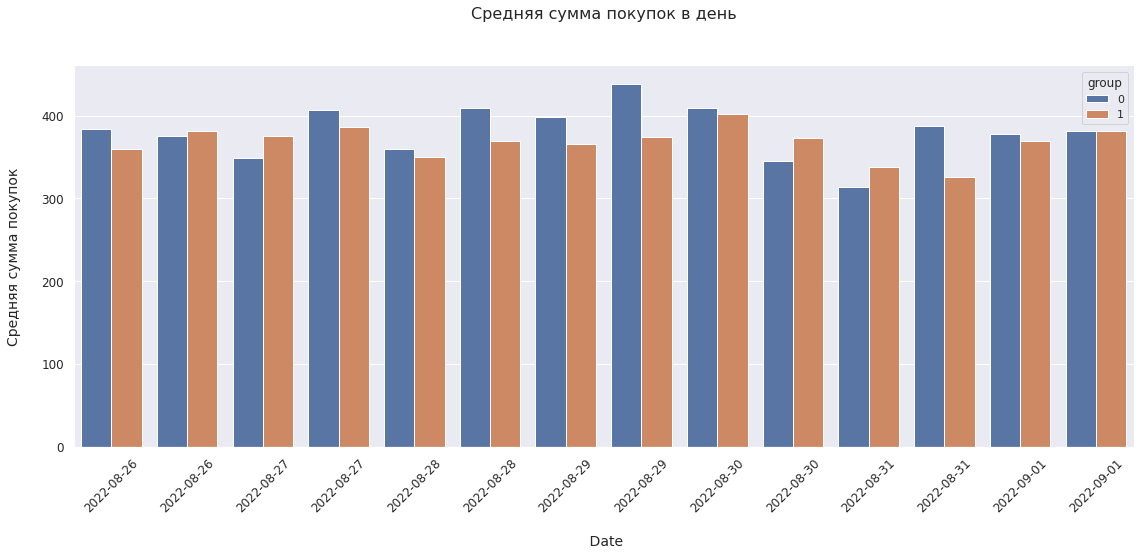

In [30]:
#построим график
ax = sns.barplot(data=df_mean_price_day, x='date', y='price', hue='group')
ax.set_title('Средняя сумма покупок в день\n') #добавили заголовок 
ax.set_ylabel('Средняя сумма покупок\n')             #добавили описание оси y
ax.set_xlabel('\n Date')                       
ax.set_xticklabels(df_mean_price_day.date.dt.date, rotation=45)
sns.despine()

In [31]:
#исследуем на нормальность
pg.normality(data=df_mean_price_day, dv="price", group="group", method="shapiro")

,W,pval,normal
0,0.975896,0.943992,True
1,0.954343,0.629920,True


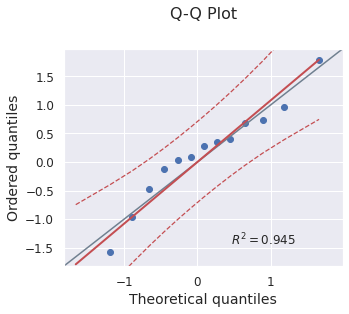

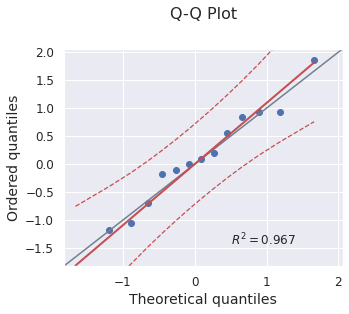

In [32]:
pg.qqplot(df_mean_price_day.query('group == 1')['price'])
pg.qqplot(df_mean_price_day.query('group == 0')['price'])

In [33]:
#применим t-test 
pg.ttest(df_mean_price_day.query('group == 1')['price'], df_mean_price_day.query('group == 0')['price'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.301044,26,two-sided,0.204656,"[-33.67, 7.57]",0.491749,0.661,0.240532


pval > 0.05 поэтому нулевую гипотезу отклонить мы не можем
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

**Проверим гипотезу: отношение заказов/отмен (значимо увеличлось/уменьшилось)**

In [34]:
#Посмотрим на сгруппированные по group и action данные:
df_users_orders \
    .groupby(['group', 'action'], as_index=False) \
    .agg({'order_id':'count'})

,group,action,order_id
0,0,cancel_order,82
1,0,create_order,1609
2,1,cancel_order,132
3,1,create_order,2514


In [35]:
#количество пользователей из группы 0
df_users_orders.query('group == 0')['user_id'].nunique()

515

In [36]:
#количество пользователей из группы 1
df_users_orders.query('group == 1')['user_id'].nunique()

502

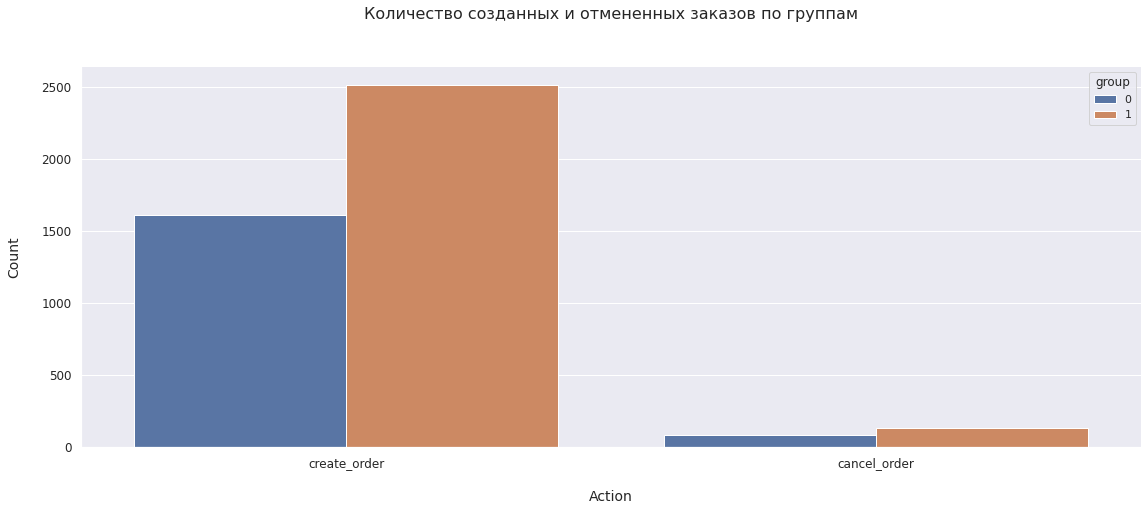

In [37]:
#построим график
ax = sns.countplot(x=df_users_orders.action, hue=df_users_orders.group)
ax.set_title('Количество созданных и отмененных заказов по группам\n') #добавили заголовок 
ax.set_ylabel('Count\n')             #добавили описание оси y
ax.set_xlabel('\nAction')                       
sns.despine()

In [38]:
#сформируем таблицу сопряженности 
df1 = pd.crosstab(df_users_orders['group'], df_users_orders['action'])
df1

action,cancel_order,create_order
group,,
0,82,1609
1,132,2514


In [39]:
#А можем сразу воспользоваться критерием хи-квадрат из библиотеки pingouin
expected, observed, stats = pg.chi2_independence(df_users_orders, x='group', y='action')

In [40]:
expected

action,cancel_order,create_order
group,,
0,83.438783,1607.561217
1,130.561217,2515.438783


In [41]:
observed

action,cancel_order,create_order
group,,
0,82.5,1608.5
1,131.5,2514.5


In [42]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,0.018211,1.0,0.892652,0.002049,0.052089
1,cressie-read,0.666667,0.018219,1.0,0.892629,0.002050,0.052090
2,log-likelihood,0.000000,0.018235,1.0,0.892583,0.002050,0.052091
3,freeman-tukey,-0.500000,0.018247,1.0,0.892548,0.002051,0.052093
4,mod-log-likelihood,-1.000000,0.018259,1.0,0.892513,0.002052,0.052094
5,neyman,-2.000000,0.018283,1.0,0.892442,0.002053,0.052097


pval > 0.05 поэтому нулевую гипотезу отклонить мы не можем
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

**Проверим гипотезу: количество заказов в день (значимо увеличилось/уменьшилось)**

In [43]:
df_not_canceled_orders.head()

,user_id,order_id,action,time,date,group,creation_time,cnt_product,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,4,408.7
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,3,250.5
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,4,310.2
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,4,228.0
5,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,2022-08-26 00:05:35,4,430.7


In [44]:
#наблюдаем разницу в средних значениях 
df_not_canceled_orders \
    .groupby(['date', 'group'], as_index=False) \
    .agg({'order_id' : 'count'}) \
    .groupby('group', as_index=False) \
    .agg({'order_id' : 'mean'}) \
    .rename(columns={'order_id' : 'orders_cnt'})

,group,orders_cnt
0,0,109.071429
1,1,170.142857


In [45]:
df_day_orders = df_not_canceled_orders \
    .groupby(['date', 'group'], as_index=False) \
    .agg({'order_id' : 'count'}) \
    .rename(columns={'order_id' : 'orders_cnt'})
df_day_orders.head()

,date,group,orders_cnt
0,2022-08-26,0,595
1,2022-08-26,1,655
2,2022-08-27,0,105
3,2022-08-27,1,186
4,2022-08-28,0,89


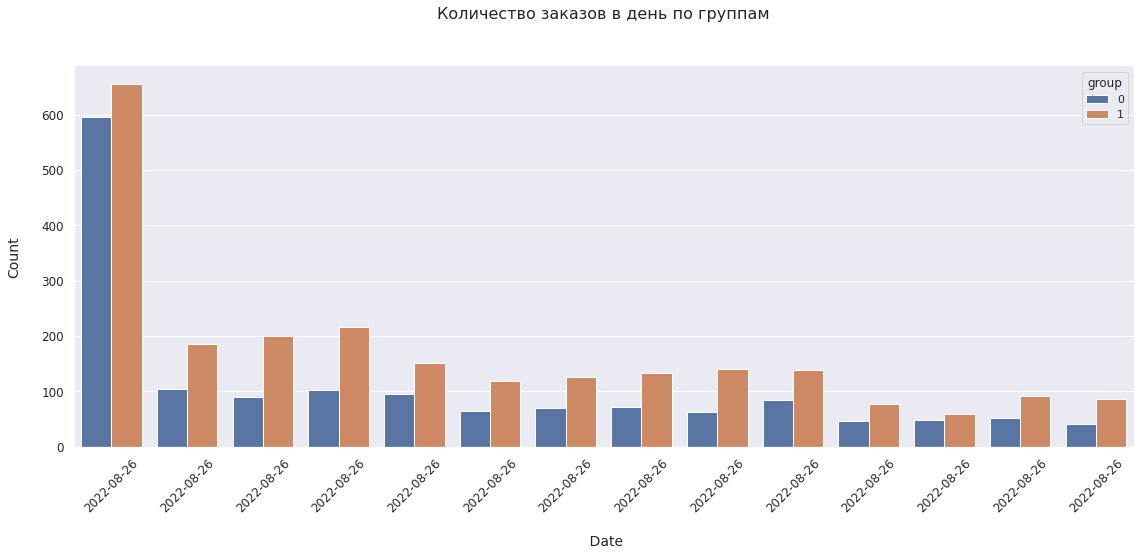

In [46]:
#построим график
ax = sns.countplot(x=df_not_canceled_orders.date, hue=df_not_canceled_orders.group)
ax.set_title('Количество заказов в день по группам\n') #добавили заголовок 
ax.set_ylabel('Count\n')             #добавили описание оси y
ax.set_xlabel('\n Date')                       
ax.set_xticklabels(df_not_canceled_orders.date.dt.date, rotation=45)
sns.despine()

In [47]:
df2 = df_day_orders[['group', 'orders_cnt']]

In [48]:
#Посмотрим являются ли распределения величин нормальными, применив метод Шапиро-Уилка
pg.normality(data=df2, dv="orders_cnt", group="group", method="shapiro")

,W,pval,normal
0,0.435538,0.000002,False
1,0.595426,0.000037,False


In [49]:
#Применим метод хи-квадрат
expected, observed, stats = pg.chi2_independence(df_not_canceled_orders, x='group', y='date')

In [50]:
expected

date,2022-08-26,2022-08-27,2022-08-28,2022-08-29,2022-08-30,2022-08-31,2022-09-01,2022-09-02,2022-09-03,2022-09-04,2022-09-05,2022-09-06,2022-09-07,2022-09-08
group,,,,,,,,,,,,,,
0,488.296239,113.675365,112.894091,124.222563,96.487337,71.486569,76.56485,80.47122,78.908672,87.502686,48.438987,41.798158,56.251727,50.001535
1,761.703761,177.324635,176.105909,193.777437,150.512663,111.513431,119.43515,125.52878,123.091328,136.497314,75.561013,65.201842,87.748273,77.998465


In [51]:
observed

date,2022-08-26,2022-08-27,2022-08-28,2022-08-29,2022-08-30,2022-08-31,2022-09-01,2022-09-02,2022-09-03,2022-09-04,2022-09-05,2022-09-06,2022-09-07,2022-09-08
group,,,,,,,,,,,,,,
0,595,105,89,102,96,64,70,72,62,85,46,48,52,41
1,655,186,200,216,151,119,126,134,140,139,78,59,92,87


In [52]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,68.814077,13.0,1.326035e-09,0.132680,0.999997
1,cressie-read,0.666667,68.758431,13.0,1.357588e-09,0.132626,0.999997
2,log-likelihood,0.000000,68.766956,13.0,1.352707e-09,0.132635,0.999997
3,freeman-tukey,-0.500000,68.878416,13.0,1.290461e-09,0.132742,0.999997
4,mod-log-likelihood,-1.000000,69.080534,13.0,1.184760e-09,0.132937,0.999997
5,neyman,-2.000000,69.760793,13.0,8.883355e-10,0.133590,0.999998


pval < 0.05 поэтому мы можем принять альтернативную гипотезу
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

**Проверим гипотезу: среднее количество продуктов в корзине на одного пользователя значимо изменилось**

In [92]:
###количество продуктов на заказ увеличилось 
df_not_canceled_orders

,user_id,order_id,action,time,date,group,creation_time,cnt_product,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,4,408.7
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,3,250.5
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,4,310.2
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,4,228.0
5,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,2022-08-26 00:05:35,4,430.7
...,...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1,2022-09-08 23:13:03,3,241.2
4333,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,1,2022-09-08 23:18:05,5,518.5
4334,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0,2022-09-08 23:22:27,3,185.9
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,3,501.9


In [93]:
#Посчитаем среднее кол-во продуктов, добавленых пользователем в корзину
user_activity = df_not_canceled_orders \
    .groupby(['user_id', 'group'], as_index=False) \
    .agg({'cnt_product' : 'mean'}) \
    .rename(columns={'cnt_product' : 'cnt_create_orders'})
user_activity

,user_id,group,cnt_create_orders
0,964,0,4.000000
1,965,1,3.666667
2,967,1,3.600000
3,968,0,3.666667
4,969,0,4.000000
...,...,...,...
1008,1976,1,3.200000
1009,1977,1,2.250000
1010,1978,1,3.166667
1011,1979,1,4.200000


In [114]:
user_activity \
    .groupby('group', as_index=False) \
    .agg({'cnt_create_orders' : 'mean'})

,group,cnt_create_orders
0,0,3.358103
1,1,3.364050


In [97]:
pg.normality(data=user_activity, dv="cnt_create_orders", group="group", method="normaltest")

,W,pval,normal
0,34.080478,3.976658e-08,False
1,48.468604,2.986595e-11,False


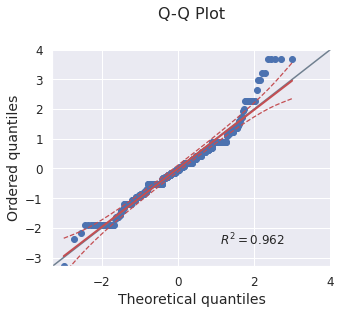

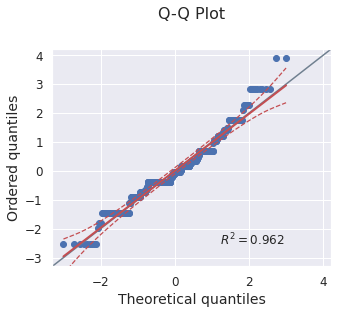

In [98]:
pg.qqplot(user_activity.query('group == 1')['cnt_create_orders'])
pg.qqplot(user_activity.query('group == 0')['cnt_create_orders'])

In [99]:
pg.mwu(user_activity.query('group == 1')['cnt_create_orders'],user_activity.query('group == 0')['cnt_create_orders'])

,U-val,alternative,p-val,RBC,CLES
MWU,132173.0,two-sided,0.398502,-0.03054,0.51527


pval > 0.05 поэтому мы не можем принять альтернативную гипотезу
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

**Проверим гипотезу: среднее количество заказов на одного пользователя значимо изменилось**

In [105]:
#Посчитаем среднее кол-во заказов на одного пользователя
user_activity_orders = df_not_canceled_orders \
    .groupby(['user_id', 'group'], as_index=False) \
    .agg({'cnt_product' : 'count'}) \
    .rename(columns={'cnt_product' : 'cnt_user_orders'})
user_activity_orders

,user_id,group,cnt_user_orders
0,964,0,2
1,965,1,9
2,967,1,5
3,968,0,3
4,969,0,2
...,...,...,...
1008,1976,1,5
1009,1977,1,4
1010,1978,1,6
1011,1979,1,5


In [110]:
user_activity_orders \
    .groupby('group', as_index=False) \
    .agg({'cnt_user_orders' : 'mean'})

,group,cnt_user_orders
0,0,2.982422
1,1,4.754491


In [107]:
pg.normality(data=user_activity_orders, dv="cnt_user_orders", group="group", method="normaltest")

,W,pval,normal
0,178.266627,1.949368e-39,False
1,17.210719,1.831217e-04,False


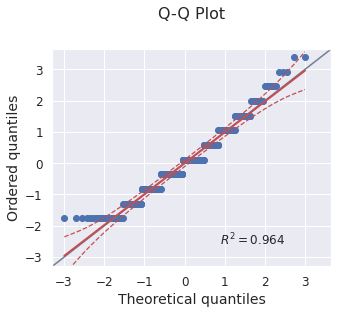

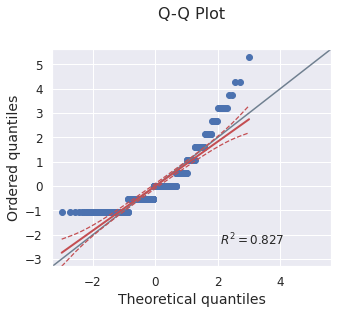

In [109]:
pg.qqplot(user_activity_orders.query('group == 1')['cnt_user_orders'])
pg.qqplot(user_activity_orders.query('group == 0')['cnt_user_orders'])

In [113]:
pg.mwu(user_activity_orders.query('group == 1')['cnt_user_orders'],user_activity_orders.query('group == 0')['cnt_user_orders'])

,U-val,alternative,p-val,RBC,CLES
MWU,193518.5,two-sided,1.219975e-45,-0.508846,0.754423


pval < 0.05 поэтому мы можем принять альтернативную гипотезу
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

**Проверим гипотезу: средняя стоимость одного продукта в корзине пользователя значимо изменилась**

In [117]:
df_not_canceled_orders = df_not_canceled_orders.copy()

In [118]:
df_not_canceled_orders['mean_price_per_unit'] = df_not_canceled_orders['price'] / df_not_canceled_orders['cnt_product']

In [119]:
df_not_canceled_orders

,user_id,order_id,action,time,date,group,creation_time,cnt_product,price,mean_price_per_unit
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,2022-08-26 00:00:19,4,408.7,102.175000
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,2022-08-26 00:02:21,3,250.5,83.500000
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,2022-08-26 00:02:27,4,310.2,77.550000
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,2022-08-26 00:03:37,4,228.0,57.000000
5,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,2022-08-26 00:05:35,4,430.7,107.675000
...,...,...,...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1,2022-09-08 23:13:03,3,241.2,80.400000
4333,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,1,2022-09-08 23:18:05,5,518.5,103.700000
4334,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0,2022-09-08 23:22:27,3,185.9,61.966667
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,2022-09-08 23:29:06,3,501.9,167.300000


In [122]:
ttttt = df_not_canceled_orders \
    .groupby(['user_id', 'group'], as_index=False) \
    .agg({'mean_price_per_unit' : 'mean'})
ttttt

,user_id,group,mean_price_per_unit
0,964,0,89.862500
1,965,1,118.563148
2,967,1,65.886667
3,968,0,142.225000
4,969,0,85.237500
...,...,...,...
1008,1976,1,122.635333
1009,1977,1,86.783333
1010,1978,1,119.962500
1011,1979,1,89.153333


In [135]:
ttttt \
    .groupby('group', as_index=False) \
    .agg({'mean_price_per_unit' : 'mean'})

,group,mean_price_per_unit
0,0,114.936647
1,1,110.559542


In [131]:
pg.normality(data=ttttt, dv="mean_price_per_unit", group="group", method="normaltest")

,W,pval,normal
0,103.503967,3.345023e-23,False
1,149.489983,3.456708e-33,False


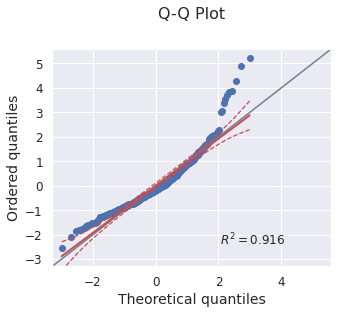

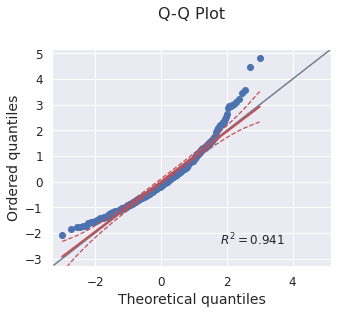

In [132]:
pg.qqplot(ttttt.query('group == 1')['mean_price_per_unit'])
pg.qqplot(ttttt.query('group == 0')['mean_price_per_unit'])

In [133]:
pg.mwu(ttttt.query('group == 1')['mean_price_per_unit'],ttttt.query('group == 0')['mean_price_per_unit'])

,U-val,alternative,p-val,RBC,CLES
MWU,122671.0,two-sided,0.230332,0.043546,0.478227


pval > 0.05 поэтому мы можем не принять альтернативную гипотезу
- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

**Итоги:**

Был проведен эксперимент в котором учавствовало две группы:

In [71]:
print(f'Первая группа со старой системой: {df_users_orders.query("group == 0")["user_id"].nunique()} пользователей\nВторая группа \
с новой системой: {df_users_orders.query("group == 1")["user_id"].nunique()} пользователя')

Первая группа со старой системой: 515 пользователей
Вторая группа с новой системой: 502 пользователя


Исследуя гипотезы, мы получили следующие резульаты :
-  Средней сумы покупок в день: **статистически значимо не изменалась**
-  Отношение Заказов к Отменам: **статистически значимо не изменилось**
-  Количество заказов в день: **Статистически значимо изменилось**
-  Среднее кол-во продуктов в корзине на одного пользователя: **статистически значимо не изменилось**
-  Среднее количество заказов на одного пользователя: **статистически значимо изменилось**
-  Средняя стоимость одного продукта в корзине пользователя: **статистически значимо не изменилась** 

Количество заказов, при почти одинаковом количестве элементов в выборках, увеличилось более чем в 1,5 раза</br>
Количество заказов на одного пользователя (т.е повторные заказы) увеличились более чем в 1,6 раза</br>

Однако, мы не наблюдаем увеличения среднего количества продуктов в корзине и увеличения средней стоимости одного продукта в корзине пользователя. Да, мы получили прирост в количестве заказов, но сказать, что это эффект от внедрения нашего алгоритма - однозначно нельзя. При внедрении рекомендательной системы, должно увеличиваться среднее кол-во продуктов в корзине пользователя, отсюда и рост среднего чека. Не хватает данных для того, чтобы оценить репрезентативность выборки (например возраст пользователя).
Стоит оценить затраты на внедрение такого алгоритма и боль осуществить ошибку первого или второго рода. А так же понять какой был ожидаемый эффект от проведения А/В теста.